# Using PyTorch to build, train, and use neural networks: A short introduction

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim 
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

## Reading a dataset and converting into a format readable by PyTorch

We are going to do multi-class classification. We have a dataset of images of digits (0 to 9). Each image is made of 16 * 16 pixels in grey scale. The training file and the test file are made of 257 columns: the first column is the label, the next 256 columns are the corresponding value for each of the 16 * 16 = 256 pixels. There is one image per row.

Let us start by reading the data.

In [2]:
df_train = pd.read_csv('zip.train', header=None, sep='\s+')
df_test = pd.read_csv('zip.test', header=None, sep='\s+')

In [3]:
print('There are {:d} images in the training set and {:d} images in the test set.'.format(len(df_train), len(df_test)))

There are 7291 images in the training set and 2007 images in the test set.


We are going to divide the datasets into images and the corresponding labels.

In [4]:
train_labels = df_train.iloc[:, 0]
train_images = df_train.iloc[:, 1:]
test_labels = df_test.iloc[:, 0]
test_images = df_test.iloc[:, 1:]

In [5]:
print('The labels are: ', sorted(train_labels.unique().astype(int).tolist()))

The labels are:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


We are now going to convert the training set and the test set into a PyTorch dataset.

In [6]:
# Dataset is a class already defined in PyTorch. We are going to create a subclass of Dataset
class ZipDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        # Let us define the attributes of a ZipDataset
        self.X = images # that will be train_images or test_images
        self.y = labels # that will be train_labels or test_labels
        # When we create an object of class ZipDataset, we can specify the transformation to apply to the data 
        self.transforms = transforms
         
    def __len__(self):
        # The length of the dataset is the number of images in the dataset
        return (len(self.X))
    
    def __getitem__(self, i):
        # How to access one pair of (image, label) from the dataset?
        # We access the ith row (which contains the 16*16 = 256 pixels of an image)
        data = self.X.iloc[i, :]
        # We tranform it into a numpy array and reshape it to an image format
        data = np.asarray(data).reshape(16, 16, 1)
        # We apply the required transformation to the image
        if self.transforms:
            data = self.transforms(data)
        # If there is a label associated to it, we return it together with the image
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

Now let us create our training and test sets.

In [7]:
train_data = ZipDataset(train_images, train_labels, transforms.ToTensor())
test_data = ZipDataset(test_images, test_labels, transforms.ToTensor())

Maybe we could have a look at one of the images.

In [8]:
index = 1048

In [9]:
data_point = train_data[index]
image = data_point[0]
label = data_point[1]

Our image looks like this:

The corresponding label is 7


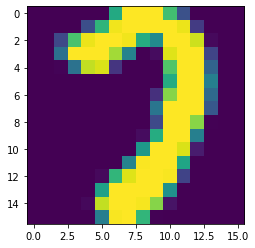

In [10]:
image = image[0,:,:].numpy()
plt.imshow(image)
print('The corresponding label is ' + str(int(label)))

Let us look at an alternative way of loading the dataset if each image is in a different file.

In [11]:
# We create another subclass of Dataset for the case where each image is in a different file
class CustomDataset(Dataset):
    def __init__(self, images_dir, labels_file=None, transforms=None):
        if labels_file is not None:
            filename = images_dir + '/' + labels_file # that will be train/label.pkl or test/label.pkl
            self.labels = pickle.load(open(filename, 'rb'))
        self.images_dir = images_dir # that will be train or test
        # When we create an object of class CustomDataset, we can specify the transformation to apply to the data 
        self.transforms = transforms

    def __len__(self):
        # The length of the dataset is the number of images in the dataset
        return len(glob.glob1(self.images_dir, '*.pkl')) - 1

    def __getitem__(self, idx):
        # How to access one pair of (image, label) from the dataset?
        # We access the ith value of the label array and the ith file in images_dir
        label = self.labels[idx]
        image_path = self.images_dir + '/image_' + str(idx) + '.pkl'
        image = pickle.load(open(image_path, 'rb'))
        # We apply the required transformation to the image
        if self.transforms:
            image = self.transforms(image)
        # If there is a label associated to it, we return it together with the image
        if self.labels is not None:
            return (image, label)
        else:
            return image

Now let us create our training and test sets.

In [12]:
train_data_alt = CustomDataset('train', 'label.pkl', transforms.ToTensor())
test_data_alt = CustomDataset('test', 'label.pkl', transforms.ToTensor())

We can now have a look at one of the images.

In [13]:
index = 1048

In [14]:
data_point = train_data_alt[index]
image = data_point[0]
label = data_point[1]

Our image looks like this:

The corresponding label is 7


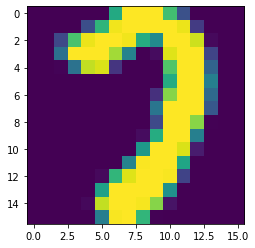

In [15]:
image = image[0,:,:].numpy()
plt.imshow(image)
print('The corresponding label is ' + str(int(label)))

The simplest neural network is a logistic regression

$y = step( \sum_{i=1}^3  (w_i x_i + b_i))$,


where $y$ is the output, $w_i$, iare the weights, $b_i$ is the biases in each neuron. It is called a Threshold Logic Unit TLU because it outputs a linear combination of the inputs, and if the result exceeds a threshold, it outputs the positive class.

![Single Neuron](TLU.png)
<!-- ![Single Neuron](singleneuron.svg) -->

A perceptron is a single kayer of TLUs, which each TLU connected to all the inputs. 

## Logistic regression: It is just a one layer neural network


In [16]:
# We create a subclass of neural networks: This one will just have one layer
class NN1(nn.Module):
    """
    Logistic regression with more than 2 classes
    """
    def __init__(self, size_img, num_classes):
        # Here we define all the functions that we will use during the forward part (data -> prediction)
        super(NN1, self).__init__()
        self.flatten = nn.Flatten() # go from a 16*16 tensor to a 256*1 tensor
        self.size_img = size_img # number of pixels in an image
        self.layer1 = nn.Linear(size_img, num_classes) # y = wx + b with w = 10*256 (10 digits * 256 pixels)

    def forward(self, x):
        # Here we explain in which order to use the functions defined above
        x = self.flatten(x)
        logits = self.layer1(x)
        return logits

We now create a model of the class NN1.

In [17]:
model = NN1(16*16, 10)

We also need to define the loss. Remember than with two classes (binary classification), we had defined:

$\log \frac{P(Y = 1)}{P(Y = 0)} = w x + b = z$.

As $P(Y = 0) + P(Y = 1) = 1$, we get $P(Y = 1) = \frac{1}{1 + e^{-z}} = \frac{1}{1 + e^{- w x - b}}$.

We can then write the probability that $Y$ takes the value $y$ (with $y$ equal to 0 or 1):

$P(Y = y) = \left(\frac{1}{1 + e^{-z}}\right)^y \left(1 - \frac{1}{1 + e^{-z}}\right)^{1 - y}$

Finally, we defined the loss:

$\mathcal{L} = - \log P(Y = y) = - (y \log \hat{y} + (1 - y) \log (1 - \hat{y})$ with $\hat{y} = \frac{1}{1 + e^{-z}}$.

We wanted to find $w$ and $b$ such that $P(Y = y)$ is maximum, which is equivalent to minimizing the loss $\mathcal{L}$.

Now with $K$ classes, we write similarly:

$\log \frac{P(Y = k)}{P(Y = K)} = (w_k - w_K) x + (b_k - b_K)$, which gives us:

$P(Y = k) = \frac{\exp(w_k x + b_k)}{\sum_{j = 1}^K \exp(w_j x + b_j)}$

This is called the _softmax_ function. Once we have found the values of the $w_k$ and $b_k$ for $k = 1 , \cdots , K$, we can compute the values of the $P(Y = k)$. We then look for which value of $k$ $P(Y = k)$ is maximal and we classify this sample as class $k$.

Similarly, we define the loss with $K$ classes:

$\mathcal{L} = - \sum_{k = 1}^K y_k \log \frac{\exp(w_k x + b_k)}{\sum_{j = 1}^K \exp(w_j x + b_j)}$. We have $y_k = 1$ if the true label associated with the sample $x$ is $k$, otherwise $y_k = 0$.

This is called the _cross-entropy loss_.

In [18]:
criterion = nn.CrossEntropyLoss()

We also need to define the gradient descent method, that we are going to use. We need to specify the learning rate.

In [19]:
optimizer = optim.SGD(model.parameters(), lr=0.001)

With stochastic gradient descent, we take the gradient and update the parameters of the model after each data sample. We need to define dataloaders that allow us to iterate over the data.

In [20]:
trainloader = DataLoader(train_data)
testloader = DataLoader(test_data)

Let us now define how to train the model.

In [21]:
def train(model, n_epochs, trainloader, testloader=None):

    # Define loss and optimization method
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001)
    
    # Save loss and error for plotting
    loss_time = np.zeros(n_epochs)
    error_time = np.zeros(n_epochs)

    # Loop on number of epochs
    for epoch in range(n_epochs):
        # Initialize the loss
        running_loss = 0
        # Loop on samples in train set
        for data in trainloader:
            # Get the sample and modify the format for PyTorch
            inputs, labels = data[0], data[1]
            inputs = inputs.float() 
            labels = labels.long()
            # Set the parameter gradients to zero
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            # Propagate the loss backward
            loss.backward()
            # Update the gradients
            optimizer.step()
            # Add the value of the loss for this sample
            running_loss += loss.item()
        # Save loss at the end of each epoch
        loss_time[epoch] = running_loss/len(trainloader)

        # After each epoch, evaluate the performance on the test set
        if testloader is not None:
            correct = 0
            total = 0
            # We evaluate the model, so we do not need the gradient
            with torch.no_grad():
                # Loop on samples in test set
                for data in testloader:
                    # Get the sample and modify the format for PyTorch
                    inputs, labels = data[0], data[1]
                    inputs = inputs.float() 
                    labels = labels.long()
                    # Use model for sample in the test set
                    outputs = model(inputs)
                    # Compare predicted label and true label
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            # Save error at the end of each epochs
            error_time[epoch] = 100 * correct / total
    
        # Print intermediate results on screen
        if testloader is not None:
            print('[Epoch %d] loss: %.3f - error: %.3f' %
              (epoch + 1, running_loss/len(trainloader), 100 * correct / total))
        else:
            print('[Epoch %d] loss: %.3f' %
              (epoch + 1, running_loss/len(trainloader)))

    # Save history of loss and test error
    if testloader is not None:
        return (loss_time, error_time)
    else:
        return (loss_time)

In [22]:
(loss, error) = train(model, 10, trainloader, testloader)

[Epoch 1] loss: 0.592 - error: 88.142
[Epoch 2] loss: 0.292 - error: 89.586
[Epoch 3] loss: 0.246 - error: 90.284
[Epoch 4] loss: 0.222 - error: 90.433
[Epoch 5] loss: 0.207 - error: 90.732
[Epoch 6] loss: 0.196 - error: 91.031
[Epoch 7] loss: 0.188 - error: 91.281
[Epoch 8] loss: 0.181 - error: 91.480
[Epoch 9] loss: 0.175 - error: 91.679
[Epoch 10] loss: 0.170 - error: 91.629


Let us now plot the evolution of the loss and the percentage of correct predictions with time:

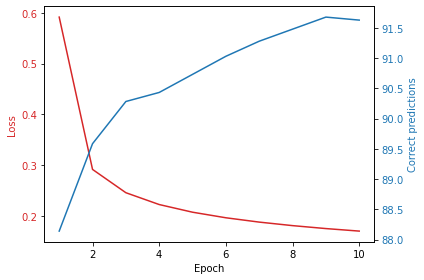

In [23]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, 11), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, 11), error, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

With stochastic gradient descent, we can also take the gradient over a subset of the sample (batch) and update the model after each batch. We can define the number of samples of the batch when we create the dataloaders

In [24]:
trainloader = DataLoader(train_data, batch_size=128, shuffle=True)
testloader = DataLoader(test_data, batch_size=128, shuffle=True)

Let us now train the model with batches. We recreate the model (otherwise, the training starts where we have ended in the previous cell).

In [25]:
model = NN1(16*16, 10)

In [26]:
(loss, error) = train(model, 20, trainloader, testloader)

[Epoch 1] loss: 2.255 - error: 28.849
[Epoch 2] loss: 2.036 - error: 37.419
[Epoch 3] loss: 1.861 - error: 44.694
[Epoch 4] loss: 1.718 - error: 51.221
[Epoch 5] loss: 1.599 - error: 57.399
[Epoch 6] loss: 1.496 - error: 62.033
[Epoch 7] loss: 1.407 - error: 65.919
[Epoch 8] loss: 1.329 - error: 68.211
[Epoch 9] loss: 1.260 - error: 70.404
[Epoch 10] loss: 1.198 - error: 72.347
[Epoch 11] loss: 1.144 - error: 73.941
[Epoch 12] loss: 1.094 - error: 75.286
[Epoch 13] loss: 1.049 - error: 76.283
[Epoch 14] loss: 1.009 - error: 77.180
[Epoch 15] loss: 0.972 - error: 78.127
[Epoch 16] loss: 0.939 - error: 78.874
[Epoch 17] loss: 0.908 - error: 79.671
[Epoch 18] loss: 0.879 - error: 80.169
[Epoch 19] loss: 0.853 - error: 80.568
[Epoch 20] loss: 0.829 - error: 80.917


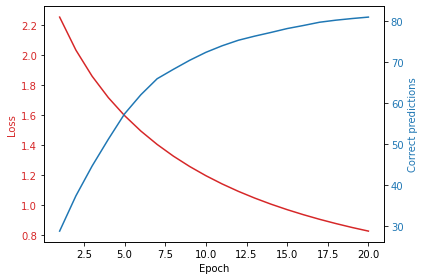

In [27]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, 21), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, 21), error, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

We could also use the dataset in the alternative format.

In [28]:
trainloader_alt = DataLoader(train_data_alt)
testloader_alt = DataLoader(test_data_alt)

In [29]:
model = NN1(16*16, 10)

In [30]:
(loss, error) = train(model, 10, trainloader_alt, testloader_alt)

[Epoch 1] loss: 0.589 - error: 87.992
[Epoch 2] loss: 0.292 - error: 89.537
[Epoch 3] loss: 0.246 - error: 90.135
[Epoch 4] loss: 0.223 - error: 90.533
[Epoch 5] loss: 0.208 - error: 90.782
[Epoch 6] loss: 0.197 - error: 91.081
[Epoch 7] loss: 0.188 - error: 91.380
[Epoch 8] loss: 0.181 - error: 91.480
[Epoch 9] loss: 0.176 - error: 91.380
[Epoch 10] loss: 0.171 - error: 91.330


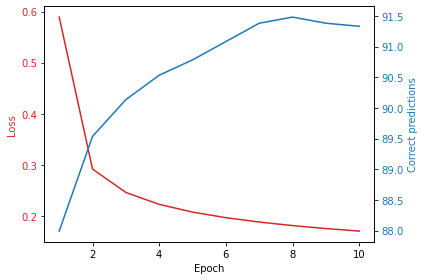

In [31]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss', color=color)
ax1.plot(np.arange(1, 11), loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Correct predictions', color=color)
ax2.plot(np.arange(1, 11), error, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()